# Import Libraries

In [1]:
%pip install keras

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from sklearn.utils import resample
from tensorflow.keras.applications import EfficientNetB0

2023-02-06 14:55:42.580300: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 14:55:42.734553: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-06 14:55:42.734586: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-06 14:55:43.653446: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Load data

In [4]:
!pip install opendatasets

In [5]:
import opendatasets as od

In [6]:
dataset = 'https://www.kaggle.com/datasets/whatsthevariance/melanoma-image-data?select=train.csv'

In [7]:
od.download(dataset)

Skipping, found downloaded files in "./melanoma-image-data" (use force=True to force download)


In [8]:
import os

In [9]:
data_dir='./melanoma-image-data'

In [10]:
os.listdir(data_dir)

['.ipynb_checkpoints', 'train', 'train.csv', 'test', 'test.csv']

In [11]:
skin_df = pd.read_csv('./melanoma-image-data/train.csv')
skin_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


# label encoding to numeric values from text

In [12]:
le = LabelEncoder()
le.fit(skin_df['benign_malignant'])
LabelEncoder()
print(list(le.classes_))

['benign', 'malignant']


In [13]:
skin_df['label'] = le.transform(skin_df["benign_malignant"]) 
print(skin_df.sample(10))

         image_name  patient_id     sex  age_approx  \
8231   ISIC_2566319  IP_9258690    male        35.0   
21862  ISIC_6617618  IP_5350484    male        30.0   
3058   ISIC_1018102  IP_3723085  female        40.0   
7474   ISIC_2334999  IP_7779275  female        45.0   
3470   ISIC_1151651  IP_9754730  female        55.0   
29237  ISIC_8841886  IP_9327025    male        50.0   
28258  ISIC_8555379  IP_0122358    male        55.0   
6316   ISIC_1984442  IP_8027787    male        75.0   
27352  ISIC_8284364  IP_3402498    male        65.0   
27600  ISIC_8352392  IP_0699776    male        80.0   

      anatom_site_general_challenge diagnosis benign_malignant  target  label  
8231                upper extremity     nevus           benign       0      0  
21862               lower extremity   unknown           benign       0      0  
3058                          torso   unknown           benign       0      0  
7474                upper extremity   unknown           benign       0    

# Data distribution visualization

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



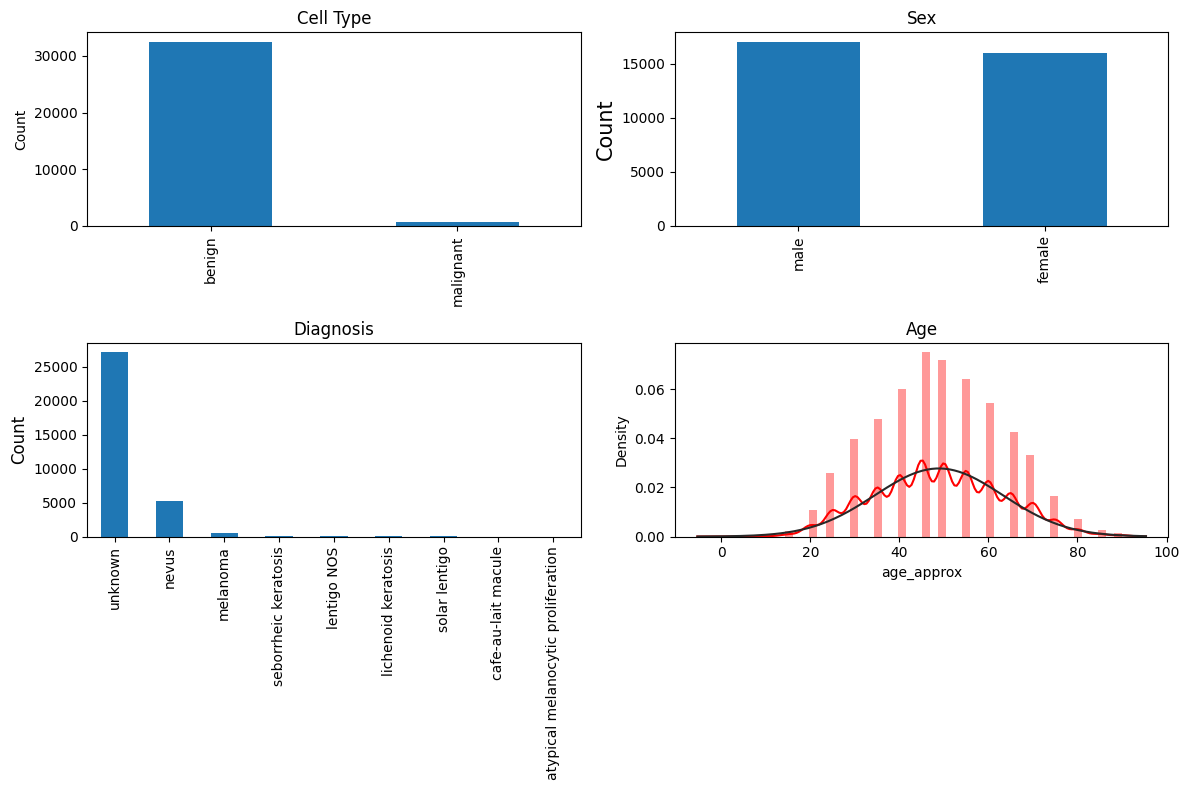

In [14]:
 fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['benign_malignant'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['diagnosis'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Diagnosis')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age_approx'])]
sns.distplot(sample_age['age_approx'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [15]:
print(skin_df['label'].value_counts())

0    32542
1      584
Name: label, dtype: int64


# Balance data.

Separate each classes, resample, and combine back into single dataframe

In [21]:
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]

n_samples=1000
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples)

In [22]:
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced])
print(skin_df_balanced['label'].value_counts())

0    1000
1    1000
Name: label, dtype: int64


# Read images based on image ID from the CSV file

In [23]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('./melanoma-image-data/train/train','*', '*.jpg'))}

# Define the path and add as a new column


In [24]:
skin_df_balanced['path'] = skin_df['image_name'].map(image_path.get)
print(skin_df_balanced.sample(10))

         image_name  patient_id     sex  age_approx  \
24408  ISIC_7408485  IP_0621614    male        40.0   
19309  ISIC_5863672  IP_9453080  female        60.0   
28688  ISIC_8677053  IP_4449605  female        55.0   
13710  ISIC_4205242  IP_6630831    male        45.0   
886    ISIC_0369831  IP_3237442    male        80.0   
18939  ISIC_5747486  IP_5715797    male        20.0   
9762   ISIC_3023646  IP_6658881    male        80.0   
19343  ISIC_5873447  IP_9754730  female        50.0   
7904   ISIC_2463014  IP_3190947  female        55.0   
14720  ISIC_4508878  IP_3010556    male        75.0   

      anatom_site_general_challenge diagnosis benign_malignant  target  label  \
24408                         torso   unknown           benign       0      0   
19309               lower extremity   unknown           benign       0      0   
28688                     head/neck  melanoma        malignant       1      1   
13710                         torso   unknown           benign       0

# Use the path to read images

In [26]:
SIZE=224
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))
print(skin_df_balanced.sample(10))

         image_name  patient_id     sex  age_approx  \
2886   ISIC_0961235  IP_8592890  female        45.0   
7726   ISIC_2408815  IP_6204577  female        65.0   
16860  ISIC_5154175  IP_2375765    male        50.0   
1658   ISIC_0600789  IP_5772279    male        70.0   
32969  ISIC_9955163  IP_7507212    male        55.0   
5263   ISIC_1670165  IP_2107539    male        55.0   
29926  ISIC_9052500  IP_7060150    male        85.0   
24414  ISIC_7410175  IP_6008814  female        90.0   
8846   ISIC_2750230  IP_5086592    male        55.0   
24962  ISIC_7577395  IP_6153406  female        40.0   

      anatom_site_general_challenge diagnosis benign_malignant  target  label  \
2886                          torso  melanoma        malignant       1      1   
7726                upper extremity  melanoma        malignant       1      1   
16860                     head/neck   unknown           benign       0      0   
1658                          torso   unknown           benign       0

# Plot images

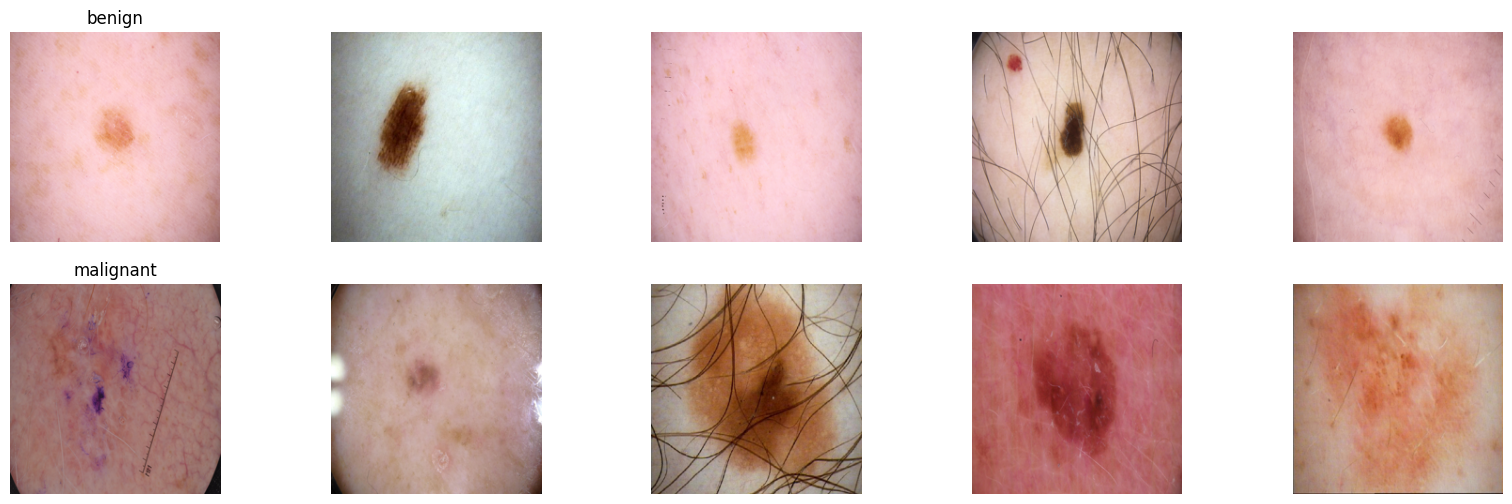

In [27]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(2, n_samples, figsize = (4*n_samples, 3*2))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['benign_malignant']).groupby('benign_malignant')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

# Convert dataframe column of images into numpy array

In [29]:
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.
Y=skin_df_balanced['label']  
Y_cat = to_categorical(Y, num_classes=2)

In [31]:
!pip install fast_ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 3.1 MB/s eta 0:00:00


In [32]:
from fast_ml.model_development import train_valid_test_split

In [37]:
from sklearn.model_selection import train_test_split
x_train, x_rem, y_train, y_rem = train_test_split(X, Y_cat, train_size=0.7)

In [38]:
x_valid,x_test,y_valid,y_test=train_test_split(x_rem,y_rem, test_size=0.6)

# Define the model

In [44]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
NUM_CLASSES = 2
IMG_SIZE = 224
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))


# Using model without transfer learning

outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

In [47]:
import tensorflow as tf
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"] )

model.summary()

hist = model.fit(x_train,y_train, epochs=30, verbose=2, validation_data=(x_valid,y_valid))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 2)                4052133   
                                                                 
Total params: 4,052,133
Trainable params: 4,010,110
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/30
44/44 - 125s - loss: 2.5611 - accuracy: 0.5779 - val_loss: 0.7172 - val_accuracy: 0.5292 - 125s/epoch - 3s/step
Epoch 2/30
44/44 - 102s - loss: 1.8007 - accuracy: 0.5914 - val_loss: 0.9419 - val_accuracy: 0.4708 - 102s/epoch - 2s/step
Epoch 3/30
44/44 - 101s - loss: 1.2249 - accuracy: 0.6429 - val_loss: 0.9471 - val_accuracy: 0.5292 - 101s/epoch - 2s/step
Epoch 4/30
44/44 - 100s - loss: 1.2097 - accuracy: 0.6914 - val_loss: 0

# plot the training and validation accuracy and loss at each epoch

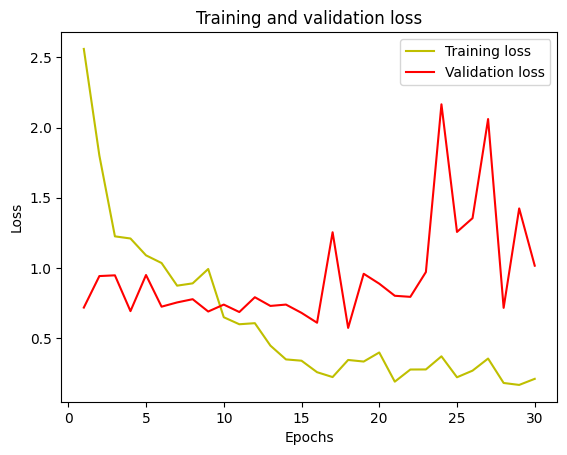

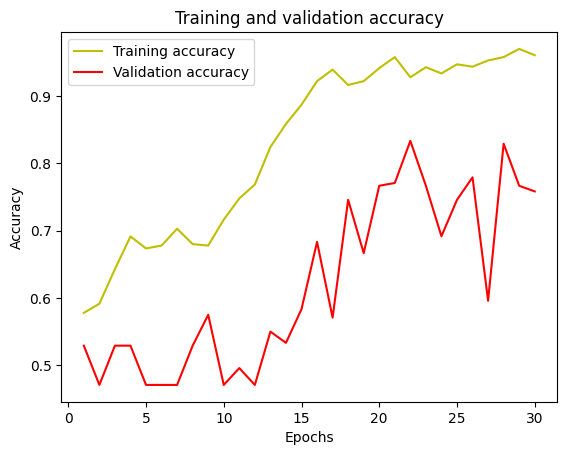

In [48]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [49]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

12/12 [==============================] - 5s 440ms/step - loss: 0.7705 - accuracy: 0.8000
Test accuracy: 0.800000011920929


# Prediction on test data

In [50]:
y_pred = model.predict(x_test)

12/12 [==============================] - 9s 578ms/step


In [51]:
print(y_pred)

[[6.13617567e-06 9.99993861e-01]
 [1.54529557e-01 8.45470488e-01]
 [1.39753133e-01 8.60246837e-01]
 [2.92331890e-07 9.99999702e-01]
 [9.84161913e-01 1.58380456e-02]
 [9.54027295e-01 4.59727235e-02]
 [7.39682093e-02 9.26031768e-01]
 [9.08114314e-01 9.18856934e-02]
 [7.11287100e-07 9.99999225e-01]
 [9.99999821e-01 7.46196349e-08]
 [4.62109574e-06 9.99995291e-01]
 [2.41566375e-02 9.75843370e-01]
 [4.29141801e-04 9.99570906e-01]
 [5.03084779e-01 4.96915251e-01]
 [1.67678520e-33 9.99999940e-01]
 [6.18365854e-02 9.38163459e-01]
 [3.12297416e-05 9.99968708e-01]
 [1.98773705e-04 9.99801159e-01]
 [9.98906195e-01 1.09377946e-03]
 [9.99969423e-01 3.04923378e-05]
 [1.93581313e-01 8.06418657e-01]
 [4.36111316e-02 9.56388891e-01]
 [9.97770131e-01 2.22980021e-03]
 [9.24798608e-01 7.52013698e-02]
 [7.05141276e-02 9.29485917e-01]
 [2.89760828e-05 9.99970973e-01]
 [9.99042094e-01 9.57841286e-04]
 [9.45359170e-01 5.46409078e-02]
 [4.01798665e-04 9.99598205e-01]
 [9.99964178e-01 3.57883946e-05]
 [9.998304

# Convert predictions classes to one hot vectors

In [52]:
y_pred_classes = np.argmax(y_pred, axis = 1) 
print(y_pred_classes)

[1 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0
 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0 0 1 0
 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 0 1 1
 0 1 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 1 0
 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 0 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 0
 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 0
 1 1 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0
 1 1 0 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1
 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0]


# Convert test data to one hot vectors

In [54]:
y_true = np.argmax(y_test, axis = 1) 
print(y_true)

[1 1 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 1 0 0
 1 1 0 1 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 0
 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 1 1
 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0 1 1 0 0 1 0 0
 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 0 1 0 0
 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 0 1
 1 1 0 0 1 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 1 0 0 0 1 1 0 1 1 0
 1 1 0 1 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 1 1 1 1
 0 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 1 1 1 0 0
 1 1 0 0 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0]


# Print confusion matrix

<AxesSubplot:>

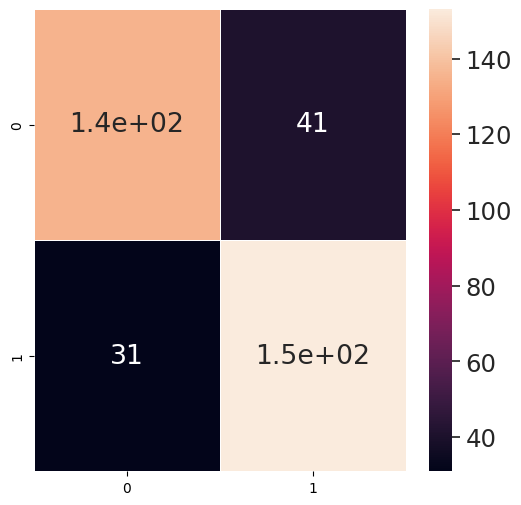

In [55]:
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

# PLot fractional incorrect misclassifications

Text(0, 0.5, 'Fraction of incorrect predictions')

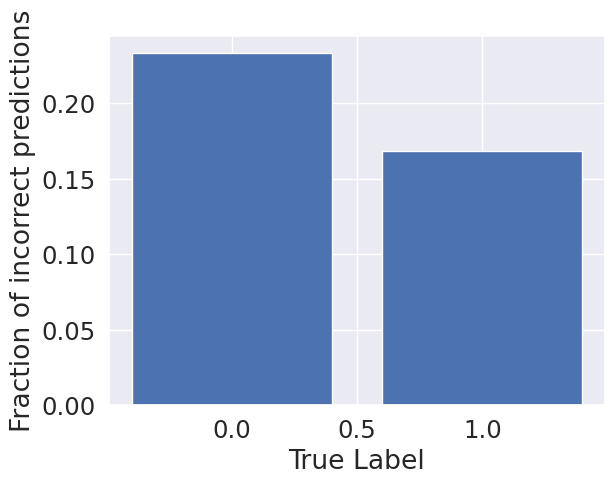

In [57]:

incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(2), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')